# <center>Data Science for Spatial Systems</center>
## <center>Final Project</center>
### <center>Image Classification and Object Detection</center>

### Note

This notebook is optimised to run fast, which implies that most of the generated data is stored as text files and read in when needed. An overview of the folders necessary to remove, in one way or another, from the directory of this file, for the script to generate all the data once again is present after the conclusion. But a word of caution, it will take a substantial amount of time – at least on my humble notebook, where the total running time is around 4-5 hours. Right now, the notebook can be executed in around 10 minutes, with most of the data being read in when needed instead of being generated. 

### Data 
https://www.kaggle.com/bhaskar2443053/fashion-small

## <center>Overview of content in this assignment</center>

* **Necessary libraries** 
* **Functions Library**
* **Introduction**
* **Methodology**
    * **Algorithms used for classification**
        * **Random Forest**
        * **Gradient Boosting**
        * **Multi-later Perceptron (Neural network)**
        * **Logistic Regression**
    * **Cross-validation**
    * **Performance Metrics**
* **Data**
* **Analysis**
    * **Benchmarking**
    * **Class Imbalance**
    * **Pre-processing**
    * **Cross-validation**
    * **Results**
* **Discussion**
* **Conclusion**
* **References**
* **Appendix**

It is possible that you need to install a few package, in order to run the script.

These are **PIL and imbalanced-learn**

Install them individually by typing the following in the console:

**PIL:**

_pip install Pillow_

**imbalanced-learn:**

_conda install -c conda-forge imbalanced-learn_

## Necessary Libraries

In [1]:
# Practicals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import os
from PIL import Image
import time
import re
# Models
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

start_total = time.time()

## Function Library

In [2]:
# This script runs summary statistics for different models. It is not intended to optimise paramters but just to show the
# performance of the models of interest. 

# Data should be a list of arrays, with features first and labels second.
# "tag" should be unique!! If you should be in dobut, print the names of the files in the predictions folder..

def evaluatePerformance(dataTrain, dataTest,classifierlist,names=None,tag=None):
    
    # Measuring the total running time
    start_total = time.time()
    
    folders = os.listdir()
    if 'predictions' in folders:
        pred_folders = os.listdir('predictions')
        iHavePredictions = any([True if tag in folder else False for folder in pred_folders])
        if iHavePredictions:
            whichFolder = [i for i,pf in enumerate(pred_folders) if tag in pf][0]
    else:
        os.mkdir('predictions')
        iHavePredictions = False
    
    # Setting up the frames we need to display the previously found results
        
    if names == None:
        names = list(np.arange(len(classifierlist)))

    resultsFrame = pd.DataFrame(index = names, columns = ['Accuracy','Precision','Recall','F1-score','Runtime'])

    # Locate unique values in the labels # Note that we can reply on this, because the loaded predictions is 
    # expected to be indentical to those we otherwise would have predicted.
    uniqueVal = sorted(pd.unique(dataTrain[1]))

    # Calculate the distribution of the observations
    observationDist = {i:sum(dataTest[1]==i) for i in uniqueVal}

    predictionsFrame = pd.DataFrame(index = ['Dataset']+names, columns = [uniqueVal])

    # Adding the distribution of observations as the first row in the prediction frame.
    predictionsFrame.loc['Dataset'] = [observationDist[col] for col in uniqueVal]
    
    if iHavePredictions:
        
        # Get the folder of interest
        tagFolder = 'predictions/'+pred_folders[whichFolder]
        # and the files needed
        predFiles = os.listdir(tagFolder)
        
        runtime = [file for file in predFiles if 'run' in file]
        predFiles = [file for file in predFiles if 'run' not in file]
        
        # For each file, load in the previously calculated predictions to make stat-table.
        for predFile in predFiles:
            
            start = time.time()
            
            with open(tagFolder+'/'+predFile,'r') as file:
                preds = np.array(file.read().split()).astype(int)
                
            # find the name of the classifier that generated that the predictions we have at hand
            name = [name for name in names if name in predFile][0]

            accuracy = sum([1 if p == l else 0 for p,l in zip(preds,dataTest[1])])/len(preds)
            precision = precision_score(dataTest[1],preds,average='weighted')
            recall = recall_score(dataTest[1],preds,average='weighted')
            f1Score = f1_score(dataTest[1],preds,average = 'weighted')

            end = time.time()

            # So, how did the classifier do, over all classes?
            results = {i:sum(preds==i) if i in preds else 0 for i in uniqueVal}

            # Adding the predictions to the prediction frame.
            predictionsFrame.loc[str(name)]=[results[col] for col in uniqueVal]

            # Adding the performance measures of the classifier to the performance frame.
            resultsFrame.loc[str(name)] = [accuracy,precision,recall,f1Score,(end-start)]
        
        with open(tagFolder+'/'+runtime[0],'r') as file:
            runtimes = np.array(file.read().split()).astype(float)
        
        resultsFrame['Runtime'] = runtimes
        
    else:
        
        # If no predictions with the tag previously has been stored, calculate the predictions, and store them in a folder
        # with that tag, to be used for future purpose. This is done to reduce running time on the final script.
        
        newFolder = 'predictions/'+tag+'_predictions'
        os.mkdir(newFolder)
        
        for classifier,name in zip(classifiers,names):
            print('Classification using %s in progress.....'%str(name))
            # Measure runtime, to include in comparison
            start = time.time()
            classifier.fit(dataTrain[0],dataTrain[1])
            
            predictions = classifier.predict(dataTest[0])
                        
            accuracy = classifier.score(dataTest[0],dataTest[1])
            precision = precision_score(dataTest[1],predictions,average='weighted')
            recall = recall_score(dataTest[1],predictions,average='weighted')
            f1Score = f1_score(dataTest[1],predictions,average = 'weighted')
            
            end = time.time()
            
            # So, how did the classifier do, over all classes?
            results = {i:sum(predictions==i) if i in predictions else 0 for i in uniqueVal}
            
            # Adding the predictions to the prediction frame.
            predictionsFrame.loc[str(name)]=[results[col] for col in uniqueVal]
            
            # Adding the performance measures of the classifier to the performance frame.
            resultsFrame.loc[str(name)] = [accuracy,precision,recall,f1Score,(end-start)]
            
            # Storing the predictions, for future use.
            with open(newFolder+'/'+str(name)+'.txt','w') as file:
                [file.write(str(prediction)+'\n') for prediction in predictions]
            
            # Storing the runtimes, because they will be just as interesting next time we wish to look at this data
        with open(newFolder+'/runtimes.txt','w') as file:
            [file.write(str(runtime)+'\n') for runtime in resultsFrame['Runtime']]
        
        end_total = time.time()
        
        print('The total running time calculating the initial predictions for the %i models was %f seconds' % (len(classifiers),
                                                                                                    (end_total-start_total)))
    return resultsFrame,predictionsFrame

In [3]:
# This function is the one provided in scikit-learn, Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [4]:
def createTrainValTest(data,labels):
    
    images = np.array(data).astype('int')
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=2019)
    # The splits are contained in the attribuate "split". We only need a subsample of 10% of the data, which is the reason why we
    # only use the first test set. We could have reversed it, such that the training set made up 90% of the total size and 
    # the test set made up 10%, but it doesn't make a difference when we only intent to plot for now!
    subsetTest = list(list(sss.split(images, labels))[0][1])
    subsetTrain = list(list(sss.split(images, labels))[0][0])

    imagesTest,labelsTest = images[subsetTest],labels[subsetTest]
    imagesTrain,labelsTrain = images[subsetTrain],labels[subsetTrain]

    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=2019)
    subsetVal = list(list(sss2.split(imagesTrain, labelsTrain))[0][1])
    subsetTrain = list(list(sss2.split(imagesTrain, labelsTrain))[0][0])

    imagesVal,labelsVal = imagesTrain[subsetVal],labelsTrain[subsetVal]
    imagesTrain,labelsTrain = imagesTrain[subsetTrain],labelsTrain[subsetTrain]

    # Calculating the distribution of the classes in each set
    observationDistTrain = {i[0]:sum(labelsTrain==i[0]) for i in enumerate(uniqueVals)}
    observationDistVal = {i[0]:sum(labelsVal==i[0]) for i in enumerate(uniqueVals)}
    observationDistTest = {i[0]:sum(labelsTest==i[0]) for i in enumerate(uniqueVals)}

    print('The data has now been splitted into training/validation/test sets, with the following proportions: \n\n(Training: %.2f, Class distribution: %s)\n\n(Validation: %.2f, Class distribution: %s)\n\n(Test: %.2f, Class distribution: %s)'%(len(labelsTrain)/len(labels),
    str(observationDistTrain),len(labelsVal)/len(labels),str(observationDistVal),len(labelsTest)/len(labels),
    str(observationDistTest)))
    
    return (imagesTrain,labelsTrain),(imagesVal,labelsVal),(imagesTest,labelsTest),(subsetTrain,subsetVal,subsetTest)

## Introduction

Internet of Things (IoT) is no longer just a buzzword, it is a massive part of our daily life. The possibilities within IoT has by no means been exhausted yet, and gains for the whole society continue to be harvested in the years to come. Today, IoT is the driven force in transitioning cities to _smart cities_, and IoT especially plays a vital role in _intelligent urban surveillance systems_ (Hu and Ni, 2017). IoT contributed to make _automated object detection_ a reality, with applications in areas such as _road traffic real-time monitoring_, _security control of restricted areas_, _automatic parking access control_ or _searching stolen vehicles_ (Hu and Ni, 2017). A fundamental part of _automated object detection_ is _image recognition_ and :image classification_, and especially the latter is the foundation in _deep learning_ algorithms for _object detection_. 

The aim of this project is performing _multi-class image classification_ using different traditional machine learning algorithms and compare their performance. A part of this comparison implies outlining necessary considerations, with respect to the data at hand, and especially how the data can be manipulated to obtain the best performance of the algorithms. 

The project proceeds as follows; Firstly, the methods used in the project is outlined, with respect to the algorithms used for classification and scoring metrics to evaluate their performance. Secondly, the data is accessed. The dataset of this project is the _Fashion-small_, consisting of around 44400 images of different clothing. The data is extracted, explored and visualised, to understand the task at hand for the applied algorithms. It is important to get a sense of the data in order to be able to make the optimal adjustments to the model configurations, to obtain optimum performance. At this stage, no pre-processing of the data is done as such. The only pre-processing applied at this stage is rescaling of the images. What follows is the analysis, initialising with benchmarking of the models of interest. Benchmarking is of interest because it allows for inference on the importance of pre-processing and parameter tuning for the individual models. The importance can vary greatly models in between. As shown shortly, no matter how the labels of the images are chosen, the dataset is imbalanced. This is partly why this dataset is interesting because this is how most real-world datasets are. It is often the case that the penalty of not detecting an observation belonging to a minority class is greater than the reward of correctly classifying an observation belonging to a majority class (Chawla et al., 2002). Class imbalance is the first thing to take care of, from there pre-processing and finally, parameter tuning follows. To round of the analysis, the final models and their performances are presented. The models are evaluated on their overall accuracy, precision, recall and the runtime to obtain the results. 
Before rounding off the project a discussion follows, of the project, the obtained results and some of the steps which have been left out for simplicity.
The cherry is the conclusion, where the project is wrapped up.  

## Methodology

This section aims at delivering a high-level description of the methods used in this project, covering the classification algorithms and the scoring metrics, used to evaluate the performance of the different classification algorithms.

### Algorithms used for classification

The methods used in this project is inspired by some of the most used methods for image classification in practical applications, i.e. some of the most award-winning algorithms in Kaggle competitions (Shridhar, 2018) (Griffiths, 2016) (Fogg, 2016). 
The algorithms employed in this project are two tree-based approaches, namely _Random Forest_ and _Gradient Boosting_, a _neural network_ and _Logistic Regression_. 
Neural networks are the most successful in image classification now, but they require quite a lot of pre-processing to perform well, as shown and discussed later.
Random Forest is powerful, especially having in mind how intuitive the method itself is.
The fellow tree-based method, Gradient Boosting, is also one of the most successful methods in Kaggle competitions. However, it is a specific application of the Gradient Boosting algorithm which brings home trophies, which will be discussed but not employed, more on that later.
Finally, the last method is Logistic Regression, which is quite simple in nature to understand and regarded as a simple first attempt (Deotte, 2018) but it is rarely a winner – on its own at least.

#### Random Forest

The Random Forest algorithm is a refined method of Bagging, and the main idea is to group a large amount of de-correlated trees and average their prediction. Bagging, also known as Bootstrap aggregating, is a variance reduction technique. The bagging estimate is the mean of the Bootstrap estimates, but the variance is given by:

<center>$ρσ^2+\frac{(1- p)}{N} σ^2$</center>

The implication of using bagging-based methods is that the expectation of the average of N bagging-based trees is the same as the expectation of an individual bagging-based tree. This implies that there is no bias reduction when averaging, and the only hope of improvement is a variance reduction of the estimate. As seen from the variance formula above, the dominating term is the correlation between the trees, as the second terms vanish as the number of trees does to infinity.

Bootstrapping sampling is when one draws a sample with replacement from the training data, with the same size as the training set. This can be done N number of times, and these N bootstrap samples can be used to make inference on the data. 

For classification purposes, the Random Forest classifier is the majority vote of the individual decision tree classifications.

The Random Forest algorithm proceeds as follows:
* For a user-specified number of trees:
    * draw a Bootstrap sample of the same size as the training data. 
    * Grow a tree, and for each terminal node, do the following until the minimum node size is reached: 
        * Select randomly m variables of the original p variables
        * select the best variable/split-point among the m variables and split it into two. 
* The Random Forest algorithm then creates an ensemble (a large group) of a predefined number of individual decision trees.

Some of the appealing features of Random Forest is the intuitive structure of trees making it easy to understand, its ability to handle both numerical and categorical data and its ability to report the feature importance for the trees, allowing for feature selection.

A thing to watch out for is that Random Forest can be prone to overfitting if the dataset is too small, but it is typically not an issue when the dataset is as big as in this project.

The most important parameters in the Random Forest is **the number of trees** and **the number of features** to consider, while more problem-specific parameters are **the minimum node size** and **the maximum depth** of a single tree (Srivastava, 2015).

The tuning parameters of interest here is, using the convention from _scikit-learn_, **max_features $(M_f)$** and **n_estimators $(N)$**. $M_f$ determines the maximum number of features that a tree in the Random Forest model can use when deciding on a split. Increasing this parameter, generally results in improved prediction power but also increased training time. 
$N$,the number of trees in the ensemble, and a higher number of trees generally imply improved prediction power and more stability of the results, but at the cost of computational complexity.

Both variables are chosen around the standard parameters, and the range of the parameters varies roughly with a constant factor. Varying the range with a constant factor, makes the results more directly comparable.

The range for $M_f$ is $M_f=(7,32,145)$, and 32 is equivalent to the standard setting, namely the square root of the number of available features (1072, at the time of performing Cross-validation). 7 and 145 is roughly a factor 4 on each side of 32. 

For $N$, the standard choice (100 trees) is the upper bound in the range, and then the two other choices of trees are chosen as a decreasing factor of 3. The range for $N$ is $N=(10,30,100)$.

#### Gradient Boosting Classifier

Gradient Boosting for classification is, just as Random Forest, an ensemble of trees itself – so-called weak learners. Each tree is a weak learner because it in itself only perform slightly better than a random guess. At each iteration, a regression tree is fitted to the negative gradient of the loss function by least squares. The implication is that the trees are continuously fitted on the weighted observations, where observations that are tougher to classify are weighted more than those which are easy to classify. So, each tree is fitted on slightly modified data, and each tree aims at correcting the errors of the previous tree because the tougher observations are weighted more heavily. (Brownlee, 2016) and (Jain, A., 2016) summarizes impressively the literature on how one should configure the GBC algorithm optimally. The recommended approach by (Jain, 2016) is doing the tuning of the model in four steps, where the first two is related to the boosting part of the model and the third if the tree-specific part;

* Settle on relatively high learning rate
* Determine the optimum number of trees for this learning rate
* Tune the tree-specific parameters
* Lower the learning rate, and increase the number of trees, to increase the robustness of the model.

The tuning parameters of the Gradient Boosting Classifier, in this project, is **max_features $(M_f)$**, **max_depth $(M_d)$** and **learning_rate $(L_r)$** (Jain, 2016) (Brownlee, 2016).

Increasing the number of trees on this dataset is computationally expensive, so a higher learning rate is explored, to compensate for the low number of trees. The learning rates explored is $L_{r}=(0.1,0.5)$. $M_f$ are chosen as in the Random Forest model, implying that the range considered is $M_{f}=(32,145)$. The $M_d$ range is chosen around the standard value of 3, with a constant factor of 1.5, implying that the range is $M_{d}=(3,5,8)$.
Both (Jain, 2016) and (Brownlee, 2016) suggests tuning the min_samples_split, but it is decided to keep it low (default value) because especially one of the minority classes has very few observations.

An appealing feature of Gradient Boosting is its ability to generalise because boosted trees are derived by optimizing an objective function (Ravanshad, 2018). So, every Gradient Boosting can be used to solve all objective functions, in which the gradient can be written. 

One potential drawback to mention is the tree-structure, as fitting one tree at a time can be a bit costly in terms of runtime, which is the case in this project. Furthermore, is the Gradient Boosting more prone to overfitting than, for example, Random Forest – which comes down to the difference between the way they construct the ensemble, namely using Bagging and Boosting. 

#### Multi-Layer Perceptron (Neural network)

Neural Networks is one of the most widely used learning methods in recent years, and it is just a nonlinear statistical model. It consists of layers of neurons, which interacts to calculate the predictions. A neural network has at least three layers and sometimes many more. The first layer is referred to as the input layer, and its size is the number of features in the data. The middle layer is usually denoted by the hidden layer, and the output layer is the predictions. For classification, the output layer can consist of everything from 1 to an arbitrary number depending on the number of classes in the data. 

The most interesting hyperparameters for a neural network is the number of hidden neurons and the regularization parameter (Deeplearning, No year). 

The choices of hyperparameters in this project are the number of **hidden neurons $(H_n)$**, and the range is $H_n=(200,500,(500,500))$. A single number implies one layer and to numbers in the parentheses implies two layers, with the specified number of neurons.

The most appealing feature of Neural Networks is the ability to solve complex problems, because of the non-linear structure. However, it is at the same time also one of the drawbacks, as this fact implies that it can seem like a black-box method. Furthermore, training does, in general, take a long time, and it is usually done using large GPU set-ups, or weights of pre-trained networks are reused on alternative problems. The last is possible because different layers capture different aspects of the problem at hand. Where the first layers capture the overall characteristics of the problem, the last layers capture the details, implying that in some circumstances the first layers can be reused on other problems, saving the training time of these (Shridhar, 2018).

#### Logistic regression

As emphasized by (Hastie et al., 2008) the logistic regression model arises from the desire to model the posterior class probabilities with linear functions in the features, while at the same time ensuring that the probabilities sum to one and remain in [0,1]. The model is shown below along with the optimization problem, with K being the classes. 

<center>$log\frac{Pr(G=i│X=x)}{Pr(G=K│X=x)} = β_{0}+β_{i}^{T}\cdot{x}\space{\space{for}}\space{\space{i}}=1,2,…,K-1$</center>
    
<center>$\min\limits_{x,c}\space{\frac{1}{2}\cdot{x^t}x+C\sum\limits_{i=1}^{n}log⁡(exp⁡(-y_{i}(β_{i}^{T}x+c))+1)}$</center>

This project utilizes the implementation in scikit-learn, where the norm in the penalization is default chosen as L2, with the penalization term being the second part of the minimization problem. From the minimization problem above, the only hyperparameter in the logistic regression model is C, which is the regularization parameter. 

This project uses the parameter in the interval $C=(0.001,0.1,1,10,100)$.

One of the appealing features of Logistic Regression is that it is easy to implement and train, because of its lack of hyperparameters (Donges, 2018). 

The disadvantage is that Logistic Regression can’t solve non-linear problems (Donges, 2018) (Hastie et al., 2008), which is not unusual when dealing with image classification, except if the images are very different.

### Cross-validation

Cross-validation is a way to evaluate an estimator or classifiers performance, with the aim of limiting the bias from overfitting. Cross-validation works by splitting the data into a user-defined number of splits $(n)$, and then, in turn, using one of the splits as the validation set and the $n-1$ splits as the training set. This procedure enables one to test a model configuration on different sets without generating or collecting more data. Furthermore, it allows one to obtain an estimate of the expected prediction/classification error on a truly unseen dataset. This is done for different model configurations, and the model configuration resulting in the lowest average error is the preferred model configuration. 

The type of Cross-validation that is utilised in this project is referred to as _stratified k-fold cross-validation_ and _stratified_ referrers here to the fact that the class proportions are maintained in each of the k folds. This is extremely relevant when dealing with an imbalanced classification problem since the folds otherwise wouldn’t be representative for the training set. The number of folds is chosen to be five, in accordance with (Hastie et al., 2008). Furthermore, implies five folds that each of the artificial test sets, within the cross-validation, has the same size as the actual test set. The implication of the artificial test sets having the same size as the actual test set is that the error rate obtained through Cross-validation is as representative as possible for the expected error rate on the test set.

### Performance metrics

The performance metrics used in this project is _Accuracy_, _Precision_, _Recall_ and _the F1-score_, with the most emphasis of the F1-score (Swalin, 2018). (Swalin, 2018) shows that the F1-score captures well misclassifications in an imbalanced dataset.

_Accuracy_ simply the proportion of correctly classified observations out of the total observations.

_Precision_ is the proportion of correctly classified true positives out of the total observations classified as positive. 

_Recall_ is the proportion of true positive observations out of the total observations being positive. 

_The F1-score_ is a balance between Precision and Recall, and they are typically weighted equally, implying that the F1-score is the average Precision and Recall. 

The above performance metrics can be evaluated on two scales, micro and macro, which are relevant if different sets are used, as in Cross-validation. For the micro measures, one sum on the individual true positives, false positives, and false negatives of different sets and use the aggregated values to define the statistic of interest. For macro measures, once take the average over different sets. The micro measures are preferred when dealing with imbalanced data (Swalin, 2018).

All the above can be derived from a confusion matrix, which are shown for all tables in Appendix. The confusion matrix visualises the predictions of each classifier, and in reveals if the misclassifications are either false positive (false alarm) or false negatives (miss). To generate the confusion matrices code from scikit-learn have been used (Pedregosa et al, 2011). Be aware that the axes are opposite of normal conventions$^{1}$, which implies that false positives are found under the diagonal and false negatives are found above the diagonal.

## Data

The data is around 44400 images of clothing, all in jpg format, and they are found in the folder _fashion-small/resized_images_ in the directory of this file. An example of an image is presented below.

The images are by default 256x256, which is an overwhelming size. It is an overwhelming size because the typical approach is to consider the pixels, either in colour (RGB) or in grey-scale, as the features of the models considered. Using the pixels as features, would for an image of the original size, imply that there were either 196.608 or 65.536 features, for colour and grey-scale picture respectively. Even with only a few images, that would be an enormous amount of data to process, and properly infeasible without a massive parallelised implementation on either cloud-computing or a powerful notebook/desktop.

Print-1: Original image of size 256x256


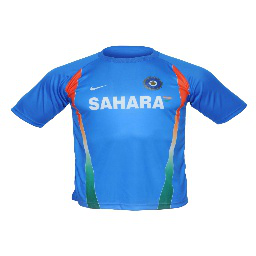

In [5]:
print('Print-1: Original image of size 256x256')
Image.open('fashion_small/resized_images/1163.jpg')

Instead, the images are resized to size 32x32, which is the same size as the images in some of the most used image-datasets, namely _CIFAR-10_ and _CIFAR-100_. The handling of the images, both importing and resizing, is done using the library _Images_ from _Pillow_. 

The preferred algorithm when shrinking images is called _LANCZOS_, and _LANCZOS_ LANCZOS is an algorithm used to perform anti-aliasing when manipulating images, it works by approximating pixels using interpolation in one way or another (Goodnight, 2011). The _LANCZOS_ filter is shown to be the best approximation to the ideal filter (Turkowski, 1990), which is the motivation for using this filter when resizing the images in the project. The _LANCZOS_ calculates the output value using a truncated sinc function on all pixels that my contribute to the output value$^{2}$. In general, one can downsample (shrink) an image without loss of quality from _anti-aliasing_ (Goodnight, 2011).

Print-2 Resized image of size 32x32


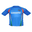

In [6]:
print('Print-2 Resized image of size 32x32')
Image.open('fashion_small/resized_images/1163.jpg').resize((32,32),Image.LANCZOS)

By default, images are kept in colour, and one image is stored in an array with all red pixels first, then green and finally blue pixels – which is the standard way of representing images numerically$^{3}$. This way of representing the images numerically implies that the data ends up being, in matrix representation, $44441\times{3072}$ big. It is read as 44441 images with a total of 3072 pixels (to becoming features later). This is one of the few times where the data is loaded every time because a test on the runtime showed that it took more time to read it back in from a text file.

In [7]:
### Load in the data, and resize it to 32x32.
directory = 'fashion_small/resized_images/'
styles = pd.read_csv('fashion_small/styles.csv')

start = time.time()
start_1 = time.time()

showWhereYouAre = np.around(np.arange(0,styles.shape[0],styles.shape[0]/10))

images = []
namesImages = []

for i,filename in enumerate(os.listdir(directory)):
    if (i in showWhereYouAre) and (i>0):
        print('The %ith image has been processed. Time spend: %.3f seconds'%(i,(time.time()-start_1)))
        start_1 = time.time()
        
    namesImages.append(int(re.sub('.jpg','',filename)))
    im = Image.open(directory+filename, 'r').resize((32,32),Image.LANCZOS)

    redPixels = [pixel[0] for pixel in list(im.getdata())]
    greenPixels = [pixel[1] for pixel in list(im.getdata())]
    bluePixels = [pixel[2] for pixel in list(im.getdata())]
    images.append(redPixels[:] + greenPixels[:] + bluePixels[:])

# Restructing the data
data = pd.DataFrame(images)
data['images'] = list(data.to_numpy())
#Check the np.arange after - needs to be based on imagesFromFile instead
data = data.drop(np.arange(len(images[0])),axis=1)

end = time.time()
print('The processing took %.3f seconds.' % (end-start))

The 4445th image has been processed. Time spend: 11.047 seconds
The 8889th image has been processed. Time spend: 10.752 seconds
The 13334th image has been processed. Time spend: 10.528 seconds
The 17778th image has been processed. Time spend: 10.076 seconds
The 22223th image has been processed. Time spend: 10.520 seconds
The 26668th image has been processed. Time spend: 10.309 seconds
The 31112th image has been processed. Time spend: 10.334 seconds
The 35557th image has been processed. Time spend: 10.241 seconds
The 40001th image has been processed. Time spend: 9.687 seconds
The processing took 138.068 seconds.


Along with the images comes an excel-sheet, found in the folder _fashion-small_, which contains metadata on each of the images. It is this meta-data which serves as labels, to be predicted later by the chosen classifiers. The categories are shown below. 

In [8]:
# Let's investigate how many unique values there are in each category of the data avaliable
potCat = list(styles.columns)
print('The categories available are:\n\n',potCat)

The categories available are:

 ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']


Of cause aren’t all categories relevant as labels, because they result in poor separation of the data. _ID_ is the image identifier so that category is irrelevant. _ProductDisplayName_ is very likely to give as many unique values as there are observations unless the same piece of clothing appears on two different images, implying this category is irrelevant as well. _Gender_ is not interesting, because it would result in a binary image classification problem, and the interest of this project is multi-class image classification. 

In [9]:
potCat = [item for item in potCat if item not in ['id','gender','productDisplayName']]
print('The remaining categories are: \n\n',potCat)

The remaining categories are: 

 ['masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage']


The interesting categories are _masterCategory_, _usages_ and _season_, and they are interesting because they provide a reasonable number of classes to the classification problem, and they all result in imbalanced classes. 

Figure 1 shows the distribution of subclasses and the distribution of observations, for each of the chosen categories. The subclasses range from five to nine, and all the interesting categories are on a varying scale imbalanced. 

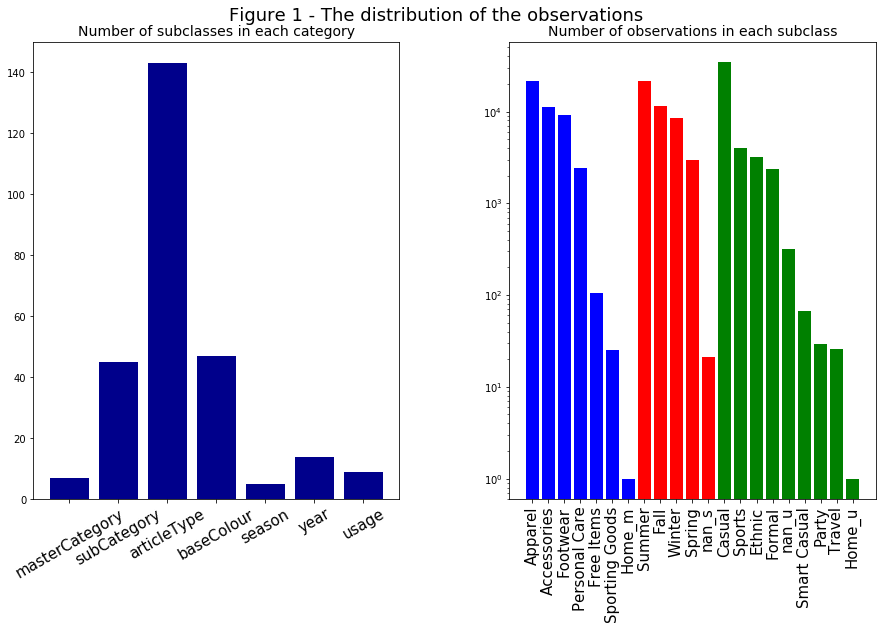

In [10]:
# Let's now see how the distribution of observations looks in each of these, and long with the number of subcategories in each.
for category in potCat:
    uniqueVals = pd.unique(styles[category])
    #print('The number of unique values in %s are %i' % (category,len(uniqueVals)),'\n')
        
# Of these seven categories seems three reasonable to continue with, namely "masterCategory", "season" and "usage".
# For each of these three, we plot the amount of observations in each of their subcategory.
chosenCat = ['masterCategory','season','usage']

styles.id = styles.id.astype('int32')
styles.masterCategory = styles.masterCategory.astype('str')
styles.season = styles.season.astype('str')
styles.usage = styles.usage.astype('str')

chosenCategoriesObsDist = []

for i,category in enumerate(chosenCat):
    uniqueVals = pd.unique(styles[category])
    #print('The potential category are: ',category,'\n')
    dataShower = {subcategory:styles[styles[category]==subcategory].shape[0] for subcategory in uniqueVals}
    sortedDataShower = sorted(dataShower.items(), key = lambda kv: kv[1],reverse = True)
    chosenCategoriesObsDist.append(sorted(dataShower.items(), key = lambda kv: kv[1],reverse = True))

# Extracting the information obtained from before, in order to plot it. 

labels = []
obs = []
colorCategory = []
colors = ['blue','red','green']

for i,e in enumerate(chosenCategoriesObsDist):
    for ele in e:
        if 'Home' in ele[0] or 'nan' in ele[0]:
            labels += [ele[0]+'_'+[i for i in chosenCat[i]][0]]
        else:
            labels += [ele[0]]
        obs += [ele[1]]
        colorCategory += [colors[i]]

obsPotCat = [len(pd.unique(styles[category])) for category in potCat]

# Plotting the figure

fig, axes = plt.subplots(1, 2,figsize=(13,8))

fig.subplots_adjust(top=0.92, left=0.07, right=0.97,
                    hspace=0.3, wspace=0.3)
(ax1, ax2) = axes
fig.suptitle('Figure 1 - The distribution of the observations',fontsize=18)
# Plotting the overall observation distribution
ax1.set_title('Number of subclasses in each category',fontsize=14)
ax1.bar(potCat,obsPotCat,color = 'darkblue')
ax1.set_xticklabels(potCat,rotation=30,fontsize = 15)

# Plotting the more elaborate class distribution
ax2.set_title('Number of observations in each subclass',fontsize = 14)
ax2.bar(labels,obs,color=colorCategory)#,color = colors[category]
ax2.set_xticklabels(labels,rotation=90,fontsize = 15)
ax2.set_yscale('log')
plt.show()

Figure 1 shows that one category, in _masterCategory_ and _usages_, namely _Home_ only have one image. Furthermore, there appears to be observations in _season_ and _usages_, which does not have information, resulting in _nans_. The dataset is cleaned for those observations, as the _nans_ have no real interpretation and the _Home_ category, with just one observation, is expected to introduce to much noise in the coming classifications, as one observation is too little knowledge to learn patterns on. This cleaning is what takes place below.

In [11]:
# Just to make sure, before we search for the observations that we intend to drop
#print(styles.dtypes)
styles.id = styles.id.astype('int32')
styles.masterCategory = styles.masterCategory.astype('str')
styles.season = styles.season.astype('str')
styles.usage = styles.usage.astype('str')

# A check to catch the observations which aren't in both the image folder and in the style sheet.
check1 = {i:0 for i in namesImages}
check2 = {i:0 for i in list(styles.id)}

# We check both way, if an images aren't in the style-sheet or the other way around
wrong1 = [(i,j) for i,j in enumerate(check1.keys()) if j not in check2.keys()]
wrong2 = [(i,j) for i,j in enumerate(check2.keys()) if j not in check1.keys()]
wrong1 = [index[0] for index in wrong1]
wrong2 = [index[0] for index in wrong2]
wrong = wrong1+wrong2
# Drop those that aren't in the both places (Five well known, in the IC community, observation)
styles = styles.drop(wrong)
styles = styles.reset_index(drop=True)

# Redo it, otherwise we don't catch all the observations because reset_index apparently tempers with the dtype...
#print(styles.dtypes)
styles.id = styles.id.astype('int32')
styles.masterCategory = styles.masterCategory.astype('str')
styles.season = styles.season.astype('str')
styles.usage = styles.usage.astype('str')

# Locating those observations that have no class in the subclass or the subclass, which only have one observation (Home)
indciesToDrop = []
namesToDrop = []
for category in potCat:
    indciesToDrop+=list(styles[(styles[category]=='Home') | (styles[category]=='nan')].index)
    namesToDrop+=list(styles[(styles[category]=='Home') | (styles[category]=='nan')].id)
    
namesToDrop = list(pd.unique(namesToDrop))
indciesToDrop = list(pd.unique(indciesToDrop))
# Let remove the names at the same time.
placeInNames = [i for i,e in enumerate(namesImages) if e in namesToDrop]
namesImages = [name for name in namesImages if name not in namesToDrop]
images = [e for i,e in enumerate(images) if i not in placeInNames]

# Dropping the located observations
print('%i observations is dropped from the data we continue with.\n' % len(pd.unique(indciesToDrop)))
styles = styles.drop(pd.unique(indciesToDrop))
styles = styles.reset_index(drop=True)
data = data.drop(pd.unique(placeInNames))
data = data.reset_index(drop=True)

# Making a last sanity check
check1 = {i:0 for i in namesImages}
check2 = {i:0 for i in list(styles.id)}

wrong1 = [(i,j) for i,j in enumerate(check1.keys()) if j not in check2.keys()]
wrong2 = [(i,j) for i,j in enumerate(check2.keys()) if j not in check1.keys()]
wrong1 = [index[0] for index in wrong1]
wrong2 = [index[0] for index in wrong2]
wrong = wrong1+wrong2

print('Everthings is good, we can continue:',wrong==[])

C:\Users\Krist\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


339 observations is dropped from the data we continue with.

Everthings is good, we can continue: True


All the observations are labelled, in each potential category. The labels, for each potential category, are seen below. 

In [12]:
# Unique entities in "master category"
masterDict = {category:i for i,category in enumerate(pd.unique(styles.masterCategory))}

# Unique entities in "Usages"
usageDict = {category:i for i,category in enumerate(pd.unique(styles.usage))}

#Unique entities in "Season"
seasonDict = {season:i for i,season in enumerate(pd.unique(styles.season))}
print('The labels in masterCategory are: \n\n',masterDict,'\n')
print('The labels in usage are: \n\n',usageDict,'\n')
print('The labels in season are: \n\n',seasonDict)

The labels in masterCategory are: 

 {'Apparel': 0, 'Accessories': 1, 'Footwear': 2, 'Personal Care': 3, 'Free Items': 4, 'Sporting Goods': 5} 

The labels in usage are: 

 {'Casual': 0, 'Ethnic': 1, 'Formal': 2, 'Sports': 3, 'Smart Casual': 4, 'Travel': 5, 'Party': 6} 

The labels in season are: 

 {'Fall': 0, 'Summer': 1, 'Winter': 2, 'Spring': 3}


In [13]:
################################ Attaching labels on each image ####################################

# Unique entities in "master category"
masterDict = {category:i for i,category in enumerate(pd.unique(styles.masterCategory))}

# Unique entities in "Usages"
usageDict = {category:i for i,category in enumerate(pd.unique(styles.usage))}

#Unique entities in "Season"
seasonDict = {season:i for i,season in enumerate(pd.unique(styles.season))}

# Getting labels
masterLabel = pd.DataFrame(index = data.index,columns=['label'])
usageLabel = pd.DataFrame(index = data.index,columns=['label'])
seasonLabel = pd.DataFrame(index = data.index,columns=['label'])

loc1 = [i for i,column in enumerate(styles.columns) if column == 'masterCategory'][0]
loc2 = [i for i,column in enumerate(styles.columns) if column == 'usage'][0]
loc3 = [i for i,column in enumerate(styles.columns) if column == 'season'][0]

############################# This is only included to reduce running time on the overall script ###############################

folders = os.listdir()

if any([True if 'data' in folder else False for folder in folders]):
    
    relevantFiles = ['masterLabel','usageLabel','seasonLabel']
     
    # Get the range of available files
    availableFiles = os.listdir('data')
    
    locations = [i for i,e in enumerate(availableFiles) if any([True if j in e else False for j in relevantFiles])]
    
    for i,location in enumerate(locations):
        name = re.sub('.txt','',availableFiles[location])
        with open('data/'+availableFiles[location],'r') as file:
            data[name] = pd.Series(np.array(file.read().split()).astype(int))

else:
###############################################################################################################################    
    for i,name in enumerate(names):

        masterLabel.loc[i] = masterDict[styles[styles.id==int(name)].iloc[0,loc1]]
        usageLabel.loc[i] = usageDict[styles[styles.id==int(name)].iloc[0,loc2]]
        seasonLabel.loc[i] = seasonDict[styles[styles.id==int(name)].iloc[0,loc3]]
    
    data['masterLabel'] = masterLabel['label']
    data['usageLabel'] = usageLabel['label']
    data['seasonLabel'] = seasonLabel['label']
###################################### included to reduce total running time #############################################    
    # Preparing to store the labels
    
    storeBles = [masterLabel,usageLabel,seasonLabel]
    relevantFiles = ['masterLabel','usageLabel','seasonLabel']

    # Make the directory
    os.mkdir('data')

    # Store the variables
    for variable,name in zip(storeBles,relevantFiles):
        with open('data/'+name+'.txt','w') as file:
            [file.write(str(obs)+'\n') for obs in variable['label']]

Now that the data has been cleaned for any redundant observations, and labels have been attached, is it time to visualise the data. It is important to visualise the data in order to get an idea about the task that lies ahead. If it is hard to distinguish the classes by the human eye, it is likely that it also will be a challenge for the algorithms at hand. There are multiple ways to visualise high-dimensional data, as 3074 dimensions in this case, in 2D or 3D, and this project utilises two of these approaches, namely _Principal Component Analysis_ (PCA) and _t-Distributed Stochastic Neighbour Embedding_ (t-SNE). The aim of any projection is to keep as much information as possible, and PCA & t-SNE does this in a varying degree, which is also seen from the visualisations based on each method. 
PCA is a linear and t-SNE is a non-linear projection method. The implication is that PCA focus on keeping low-dimensional representations of dissimilar datapoints far apart (Van Der Maaten and Hinton, 2008). However, in some cases, its often more important to keep the low-dimensional representations of very similar data points close together (Van Der Maaten and Hinton, 2008), which is typically not possible with a linear mapping, which motivates the exploration of the non-linear t-SNE method.

Principal Component Analysis are a part of the unsupervised tool-kit and is basically the best linear approximations of the high-dimensional data (Hastie et al., 2008). Projecting the high-dimensional data using the principal components allows one to visualise high-dimensional data in 2D or 3D by using either the first two or first three principal components. A nice property of the principal components is, that they are ranked by their ability to explain the variance in the original data, meaning that the first principal component is the linear approximation of the original data, which explains the greatest amount of variation in the original data. This property is useful to gain an understanding of the complexity of the data at hand, and it can be utilised, which is illustrated shortly. 

The explained variance of the first two principal components are 0.417 


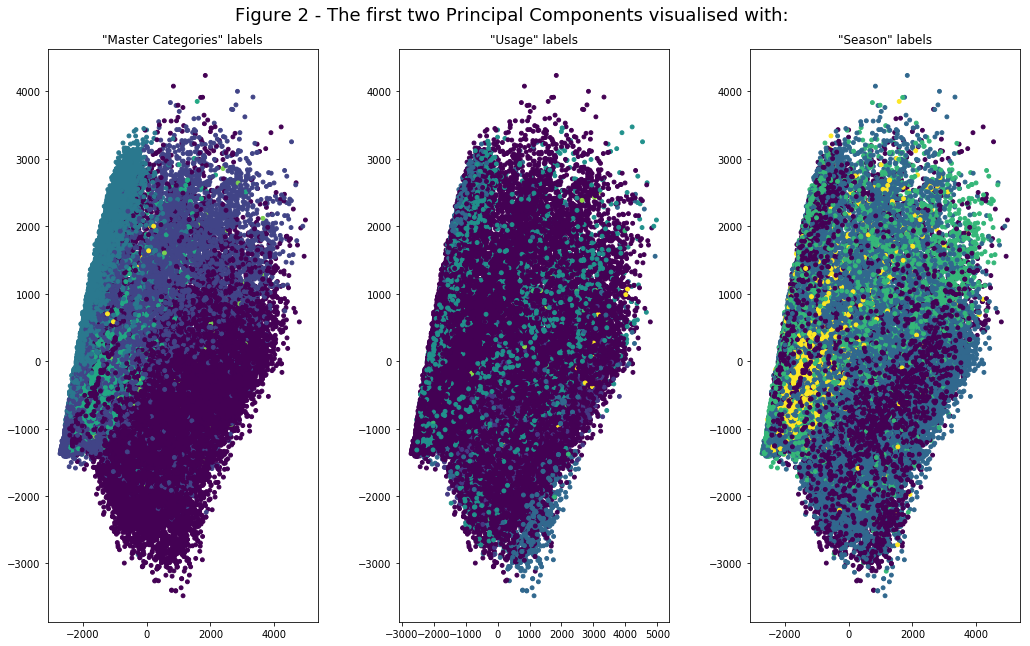

In [14]:
imagesNP = np.array(images)
# Subsetting labels to begin with
labelsMNP = np.array(data['masterLabel'])
labelsUNP = np.array(data['usageLabel'])
labelsSNP = np.array(data['seasonLabel'])

# Performing 2d PCA

pca = PCA(n_components=2)
imagesPCA = pca.fit_transform(images)

# Let's see what the explained variance are
print('The explained variance of the first two principal components are %.3f ' %sum(pca.explained_variance_ratio_))

fig, axes = plt.subplots(1, 3,figsize=(15,10))

fig.subplots_adjust(top=0.92, left=0.07, right=0.97,
                    hspace=0.3, wspace=0.3)
(ax1, ax2, ax3) = axes
fig.suptitle('Figure 2 - The first two Principal Components visualised with:',fontsize=18)
# PLotting with masterlabels
ax1.scatter(imagesPCA[:,0],imagesPCA[:,1],15,labelsMNP)# <- The last input ensures coloring by label! 
ax1.set_title('"Master Categories" labels')

# Plotting with masterlabels
ax2.scatter(imagesPCA[:,0],imagesPCA[:,1],15,labelsUNP)# <- The last input ensures coloring by label!
ax2.set_title('"Usage" labels')

# Plotting with seasonLabels
ax3.scatter(imagesPCA[:,0],imagesPCA[:,1],15,labelsSNP)# <- The last input ensures coloring by label!
ax3.set_title('"Season" labels')

plt.show()

Figure 2 shows the 2D projections of the high-dimensional data using PCA. It is noticed that the classes are difficult to distinguish, and at this point, it is difficult to say whether it is due the capabilities of PCA or due to the nature of the clothing categories. However, the first two components only explain 42% of the variation in the data, and this could indicate that the poor visualisation is due to PCA’s shortcomings in handling this type of data.

The data is projected to the first fifty principal components before being projected using t-SNE and visualised, as of recommendations by van der Maaten$^{4}$. It is seen below, that the first fifty principal components explain over 85% of the variations, and these are used to project the data using t-SNE.

In [15]:
# Performing 50d PCA

pca50 = PCA(n_components=50)
imagesPCA50 = pca50.fit_transform(images)

print('The explained variance of the fifty first principal components are %.3f ' %sum(pca50.explained_variance_ratio_))

The explained variance of the fifty first principal components are 0.853 


t-SNE is one among many nonlinear dimensionality reduction techniques, and common for all of them is that they aim a preserving both the local and global structure in the high-dimensional data, in their projections. Many of these techniques have been shown not to capture both the local and global structure very well on real-world datasets, which was the motivation behind the construction of t-SNE (Van Der Maaten and Hinton, 2008). t-SNE is shown to outperform a range of seven other techniques for reducing dimensions of high-dimensional real-world datasets (Van Der Maaten and Hinton, 2008), which is the motivation for using t-SNE in this project. The projection and grouping of similar data points done using t-SNE are done using conditional probabilities instead of Euclidean distance, for a detailed explanation see (Van Der Maaten and Hinton, 2008).

In [16]:
folders = os.listdir()

if any([True if 't-SNE' in folder else False for folder in folders]):
    relevantFiles = ['tsne_results50_0','tsne_results50_1']
    neededFiles = [] 
    # Get the range of available files
    availableFiles = os.listdir('t-SNE')

    locations = [i for i,e in enumerate(availableFiles) if any([True if j in e else False for j in relevantFiles])]

    for i,location in enumerate(locations):
        with open('t-SNE/'+availableFiles[location],'r') as file:

            neededFiles.append(np.array(file.readlines()).astype(float))

    tsne_results50M = np.array([[i,j] for i,j in zip(neededFiles[0],neededFiles[1])])
    
else:
    
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
    print('Calculating the reduced dimensions for the masterCategory-dataset\n')
    tsne_results50M = tsne.fit_transform(imagesPCA50)#subImagesPCA50M


    storeBles = [tsne_results50M]
    relevantFiles = ['tsne_results50']
    
    # Make the directory
    os.mkdir('t-SNE')

    # Store the variables
    for variable,name in zip(storeBles,relevantFiles):
        with open('t-SNE/'+name+'_0.txt','w') as file:
            [file.write(str(obs[0])+'\n') for obs in variable]
        with open('t-SNE/'+name+'_1.txt','w') as file:
            [file.write(str(obs[1])+'\n') for obs in variable]
    
    print('\nt-SNE done! Time elapsed: %.3f seconds'%(time.time()-time_start))

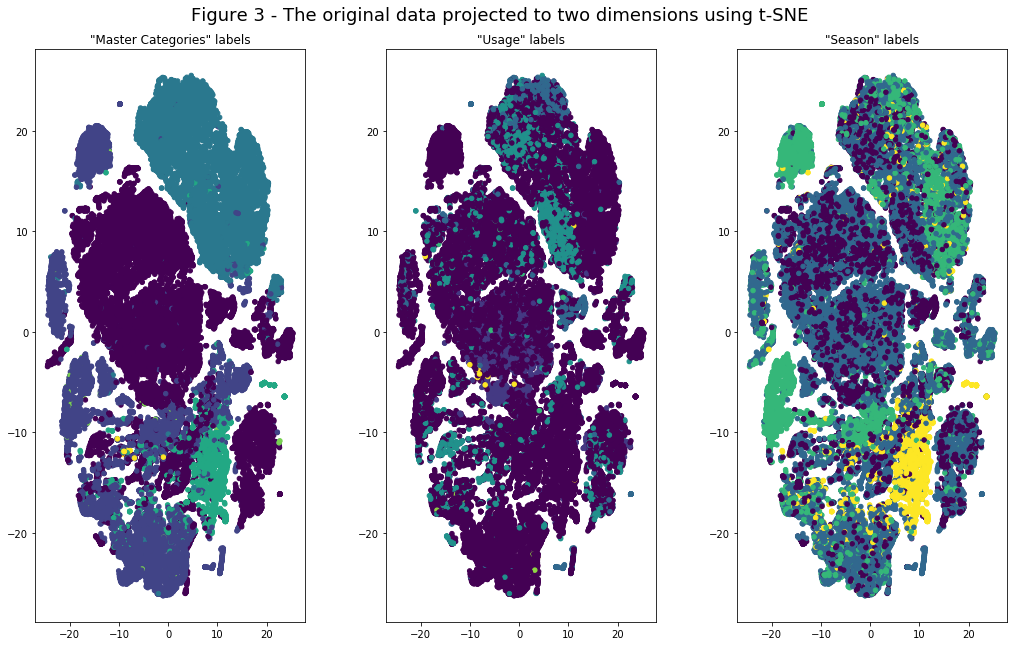

In [17]:
fig, axes = plt.subplots(1, 3,figsize=(15,10))

fig.subplots_adjust(top=0.92, left=0.07, right=0.97,
                    hspace=0.3, wspace=0.3)
(ax1, ax2, ax3) = axes
## Correct the title!!
fig.suptitle('Figure 3 - The original data projected to two dimensions using t-SNE',fontsize=18)
# PLotting with masterlabels
ax1.scatter(tsne_results50M[:, 0], tsne_results50M[:, 1], 20, labelsMNP)# <- The last input ensures coloring by label! 
ax1.set_title('"Master Categories" labels')

# Plotting with masterlabels
ax2.scatter(tsne_results50M[:, 0], tsne_results50M[:, 1], 20, labelsUNP)# <- The last input ensures coloring by label!
ax2.set_title('"Usage" labels')

# Plotting with seasonLabels
ax3.scatter(tsne_results50M[:, 0], tsne_results50M[:, 1], 20, labelsSNP)# <- The last input ensures coloring by label!
ax3.set_title('"Season" labels')

plt.show()

Figure 3 shows the results of the t-SNE projection of the high-dimensional data to the two-dimensional subspace. The first graph shows the projected data coloured using the _masterCategory_ labels, and the graph shows signs of some clear clusters of observations, yet some overlapping occurs in the bottom. The second graph shows the projected data coloured using the _usages_ labels, and this graph visualises the takeaway from figure 1 with respect to the _usages_ labels, namely what one subcategory, _Casual_, dominates this subcategory, it and that _usages_ in general is a poor separator of the data. The third graph shows the projected data coloured using the _season_ labels and shows no clear tendency. Based on figure 3, it is decided to continue with the _masterCategory_ labels as the preferred labels. 

In [18]:
uniqueVals = pd.unique(styles['masterCategory'])
print('The chosen category are: masterCategory\n')
dataShower = {subcategory:styles[styles['masterCategory']==subcategory].shape[0] for subcategory in uniqueVals}

sortedDataShower = sorted(dataShower.items(), key = lambda kv: kv[1],reverse = True)

result=[print('The number of observations in "%s" are %i'%(sortedDataShower[i][0],
                                                    sortedDataShower[i][1])) for i in np.arange(len(uniqueVals))]

The chosen category are: masterCategory

The number of observations in "Apparel" are 21370
The number of observations in "Accessories" are 11261
The number of observations in "Footwear" are 9200
The number of observations in "Personal Care" are 2141
The number of observations in "Free Items" are 105
The number of observations in "Sporting Goods" are 25


## Analysis

With the labels in place, is it time to split the data into a training, validation and test set. This is done to eliminate the bias in the classifications, by ensuring the models aren’t overfitting to the data.

The way the data is splitted is using what is called _stratified k-folds_, which splits the data into a desired split but at the same time maintaining the class distribution of the total dataset.
The procedure used in _createTrainValTest_ is to split the data into an 80/20 split, where 80% of the data is training data and 20% of the data is test data. This ratio is the conventional split used in the machine learning community. The training set is split once more, to obtain a validation set, but this time into a 75/25 split, which implies that the final size of the sets is 60/20/20 for training, validation and test respectively. Separating the data in this way is desired, because the validation and test set should be as representative for each other as possible, to ensure as much generalisation as possible. 

In [19]:
# Create our 60/20/20 desired train/val/test splitted data

train,validation,test,subsets = createTrainValTest(images,labelsMNP)

imagesTrain,labelsTrain = train[0],train[1]
imagesVal,labelsVal = validation[0],validation[1]
imagesTest,labelsTest = test[0],test[1]
subsetTrain,subsetVal,subsetTest = subsets[0],subsets[1],subsets[2]

The data has now been splitted into training/validation/test sets, with the following proportions: 

(Training: 0.60, Class distribution: {0: 12821, 1: 6756, 2: 5520, 3: 1285, 4: 63, 5: 15})

(Validation: 0.20, Class distribution: {0: 4275, 1: 2252, 2: 1840, 3: 428, 4: 21, 5: 5})

(Test: 0.20, Class distribution: {0: 4274, 1: 2253, 2: 1840, 3: 428, 4: 21, 5: 5})


The purpose of the validation set is to have something to run benchmark results on, such that the test set stays truly unseen over the entire process.
The idea with obtaining benchmark results, on the standard model configurations for the chosen models, is to quantify the effect of parameter tuning and the pre-processing. 

### Benchmarking

In [20]:
#################################################### Define models below ####################################################

# Random Forest
rfCl = RandomForestClassifier(n_estimators=100, max_depth=None,n_jobs=-1)

# Multi-layer Perceptron (Neural Network)
mlpCl = MLPClassifier(solver='adam', alpha=1e-5,learning_rate = 'constant',
                      hidden_layer_sizes=(200,),batch_size = 'auto')

# Gradinent Boosting Classifier
gbCl = ensemble.GradientBoostingClassifier(n_estimators=10,n_iter_no_change=10,subsample = 0.5)

# Logistic Regression Classifier
lrCl = LogisticRegression(solver='lbfgs',multi_class='multinomial',n_jobs=-1)

# Combine the classifiers to a list 
classifiers = [rfCl,mlpCl,gbCl,lrCl]

# Specify names for the classifiers, otherwise will they be name by numbers.... Which you obiviously don't want.. Do you?
names = ['RandomForest','MultiLayerPerceptron','GradientBoosting','LogisticRegression']

# Let's run some models
results, predictions = evaluatePerformance([imagesTrain,labelsTrain],[imagesVal,labelsVal],classifiers,names,'initial_2')

C:\Users\Krist\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Krist\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
print('The dimensions of the training data is:\n\nFeatures: %i\nObservations: %i' %(len(imagesTrain[0]),len(imagesTrain)))
print('\nThe dimensions of the validation data is:\n\nFeatures: %i\nObservations: %i' %(len(imagesVal[0]),len(imagesVal)))

The dimensions of the training data is:

Features: 3072
Observations: 26460

The dimensions of the validation data is:

Features: 3072
Observations: 8821


In [22]:
print('Table 1 - Benchmarking Results')
results

Table 1 - Benchmarking Results


,Accuracy,Precision,Recall,F1-score,Runtime
RandomForest,0.978234,0.975505,0.978234,0.976726,18.405103
MultiLayerPerceptron,0.909647,0.940072,0.909647,0.917705,639.416157
GradientBoosting,0.917356,0.915235,0.917356,0.91537,175.394064
LogisticRegression,0.946151,0.945727,0.946151,0.944728,107.474534


In [23]:
print('Table 2 - Benchmarking Predictions')
predictions

Table 2 - Benchmarking Predictions


,0,1,2,3,4,5
Dataset,4275,2252,1840,428,21,5
RandomForest,4334,2271,1828,387,1,0
MultiLayerPerceptron,4140,1863,1846,972,0,0
GradientBoosting,4395,2329,1771,325,0,1
LogisticRegression,4291,2321,1825,383,1,0


The results from the benchmarking are seen in table 1 and table 2. The accuracy of the standard configuration’s ranges from 90.6% to 97.8%, with the neural network being the worst and the random forest being the best performer. An interesting observation, seen from table 2, is that none of the models learns the characteristics of the minority classes, despite Random Forest having an accuracy of 97.8%, as an example. So, is that great performance, even for Random Forest? We should expect a performance of 99.7%, if we classified every observation correctly, except for the minority classes. So, there is room for improvement across all models.
A sub-aim of this project is to try to detect the minority classes, as the consequences of not catching a minority can be devastating, compared to not catching a majority class. It is investigated if that is achievable by correcting the class-imbalance and the tune the model configurations through Cross-validation. A final thing to note, from table 1, is the significant variation in runtime between the different models. There is a difference of a factor 34 between Random Forest, the fastest, and the neural network, the slowest. 

### Time to correct the imbalance in the dataset

A step towards improving the classification of the minority classes is to correct the imbalance in the dataset. To correct the imbalance in the classes of the dataset, a sampling technique named SMOTE, Synthetic Minority Over-sampling Technique proposed by (Chawla et al, 2002), is utilised. The sampling technique is found in the imbalanced-learn library. SMOTE works by over-sampling the minority classes and under-sampling the majority classes, and in that way balancing the classes of the dataset. 
The timing of the oversampling matters and the correct time to do it is after the dataset is split into training, validation and test sets (Becker, 2016). By oversampling after the splitting has been done, ensures that no information is shared between the training set and the validation set, which minimizes overfitting. 

The benchmark models are tested on the oversampled data, to see the effect of the oversampling, which is presented in table 3 and 4 below.

In [24]:
start = time.time()
# Sample the data
sm = SMOTE(random_state=2019,n_jobs = -1)
imagesTrainSMOTE, labelsTrainSMOTE = sm.fit_resample(imagesTrain, labelsTrain)

print('It took %.3f seconds to sample the training data.\n\n'%(time.time()-start))

# Class distribution in the sampled data
print('The class distribution in sampled data is: \n')

print({i:sum(labelsTrainSMOTE==i)/len(labelsTrainSMOTE) for i in sorted(pd.unique(labelsTrainSMOTE))})

It took 150.288 seconds to sample the training data.


The class distribution in sampled data is: 

{0: 0.16666666666666666, 1: 0.16666666666666666, 2: 0.16666666666666666, 3: 0.16666666666666666, 4: 0.16666666666666666, 5: 0.16666666666666666}


In [25]:
# We can now try and run our classifications on the benchmark models again, and see if 
# resampled have implied an improvement on it's own.

# Respecifying the classifiers and names
classifiers = [rfCl,mlpCl,gbCl,lrCl]
names = ['RandomForest','MultiLayerPerceptron','GradientBoosting','LogisticRegression']

# Let's run some models
resultsSMOTE, predictionsSMOTE = evaluatePerformance([imagesTrainSMOTE,labelsTrainSMOTE],[imagesVal,labelsVal],
                                                     classifiers,names,'initialSMOTE')

C:\Users\Krist\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Krist\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
print('The dimensions of the training data is:\n\nFeatures: %i\nObservations: %i' %(len(imagesTrainSMOTE[0]),
                                                                                    len(imagesTrainSMOTE)))
print('\nThe dimensions of the validation data is:\n\nFeatures: %i\nObservations: %i' %(len(imagesVal[0]),len(imagesVal)))

The dimensions of the training data is:

Features: 3072
Observations: 76926

The dimensions of the validation data is:

Features: 3072
Observations: 8821


In [27]:
print('Table 3 - Results on SMOTE-oversampled data')
resultsSMOTE

Table 3 - Results on SMOTE-oversampled data


,Accuracy,Precision,Recall,F1-score,Runtime
RandomForest,0.979141,0.977124,0.979141,0.978077,71.066766
MultiLayerPerceptron,0.2553,0.0651854,0.2553,0.103854,288.157000
GradientBoosting,0.800363,0.909,0.800363,0.84251,578.173848
LogisticRegression,0.890942,0.930785,0.890942,0.907412,98.850807


In [28]:
print('Table 4 - Predictions based on SMOTE-oversampled data')
predictionsSMOTE

Table 4 - Predictions based on SMOTE-oversampled data


,0,1,2,3,4,5
Dataset,4275,2252,1840,428,21,5
RandomForest,4276,2275,1825,440,3,2
MultiLayerPerceptron,0,8820,1,0,0,0
GradientBoosting,3504,1770,1811,930,644,162
LogisticRegression,3982,2004,1847,659,301,28


Table 3 shows that the benchmark classifiers benefit of the oversampled data with a varying degree. The neural network can't handle the oversampled data at all, presumably because of its too simple structure (one layer, 200 neurons to classify high-dimensional-multi-class data). 
The Random Forest classifier benefits a bit of the oversampled data, with a minor increase in both Accuracy and F1-score. Both the Gradient Boosting and the Logistic Regression classifier loses some classification power, in terms of reduced accuracy and F1-score. The main takeaway from the effect of the oversampling is not improved/reduced performance, but the fact that two out of four classifiers seems to have learnt the dynamics of the minority class, which is seen from the confusion matrices belonging to table 4, see in appendix. An interesting observation is that it is Gradient Boosting and Logistic Regression, those two who appeared to lose prediction power, which seem to have learnt the dynamics of the minority classes, albeit on the cost of the majority classes. With that in mind, is it a suitable time to consider the pre-processing of the data, which can be done to improve the performance of the models.

## Pre-processing

There are different ways in which image data can be pre-processed, and some of them are listed below.

* Grey-scaling
* Scaling
* Subtracting mean of related pixels (mean of columns)
* PCA
* Rotation
* Cropping

Only _grey-scaling_ and _scaling_ is relevant for this project, because it reduces the dimensions of the data in a natural way, and it doesn’t change the interpretation of the images themselves. The reduction of the dimensions of the data enables one to perform Cross-validation of the models and their configurations, without the use of GPU-computing, since Cross-validation is a computationally demanding task with so much high-dimensional data, as it is the case for this project. 

None of the images is rotated, and all the images are squared-sized, meaning that they have equal height and width, implying that _cropping_ is redundant. However, it seems natural to touch lightly upon the alternative ways of pre-processing the images before continuing with the project.

_Grey-scaling_ is when images are converted from being colour images to be different shades of grey. This reduces the number of dimensions by a factor three because the RGB values for the pixels are combined to one value per pixel. For the images used in this project, that implies that the dimensions of 32x32 images reduce from 3072 to 1024, which is a substantial reduction. The reduced dimensions have a major effect on the runtime for some of the classifiers, which can be seen comparing table 1,3 and 5. Table 1 displays the benchmark results, where the dimensions of the data are 3072 and the total processed observations are 35281. Comparing the runtime of the classifiers in table 3, where the total observations are more than doubled as a result of SMOTE oversampling, with the runtime listed in table 1, shows that an algorithm as Gradient Boosting appears to scale badly in observations. However, table 5 shows that Gradient Boosting’s bad scaling from table 3 is due to the high dimensions of the data, underlying table 1 and 3. The same conclusion can be made for Logistic Regression, which scales badly in dimensions compared to the number of observations. Differently, scales Random Forest good in features, and is mainly affected by the number of observations. The reason for this is because Random Forest typically uses a very limited number of features when choosing the split. However, this is a tuning parameter, which is being tuned in the coming Cross-validation. 

_Scaling_ is when the size of the images is changed, with up or down, depending on whether up-scaling or down-scaling is performed. This is what was described in the initial description of the data, in the section Data, where the algorithm used for downscaling of the initial images was LANCZOS. Rescaling images significantly reduces the dimensions of the data, from 196.608 features in the original 256x256 images, to 3072 features in the 32x32 downscaled images. In general, one can downsample (shrink) an image without loss of quality from anti-aliasing (Goodnight, 2011).

_Subtracting the mean of equal located pixels_ is in some sense related to changing the contrast of images, which can be useful if the images are taken doing both day and night. As mentioned, normalisation of this type is not relevant for the images used in this project, because all of them are taken in the same setting. 

_Principal Components Analysis_ can be used to reduce the dimensions of the data as well. However, then using PCA-reduced data, one loses most of the interpretation in the features, since the components from PCA are nothing more than the best linear approximations of the high-dimensional data. This pre-processing step isn’t considered in this project, because it is preferred to maintain the interpretation of the features, by using _grey-scaling_ of the images instead.

_Rotation_ is simply rotating images, in a way such the two motives, which are identical but hard to identify because of one of the motives being rotated compared to the other, are being labelled identically. This transformation is neither relevant because none of the images is rotated.

_Cropping_ is when images are being cropped, such that they have equal width and height, to ensure that all images have the same number of features. This is neither relevant, as all images are squared from the beginning. 

As mentioned earlier, _grey-scaling_ is one of the few pre-processing steps applied in this project, and the effect can be seen below. The grey-scaling is based on the methodology listed in the library Pillow$^{5}$ , used to read in the images at the beginning of the project. 


In [29]:
pixels = len(imagesTrainSMOTE[0])/3
redRange = np.arange(0,pixels).astype(int)
greenRange = np.arange(pixels,pixels*2).astype(int)
blueRange = np.arange(pixels*2,pixels*3).astype(int)

In [30]:
##################################### Converting the colour images to grey-scaled images ####################################
start = time.time()

imagesTrainGrey = []
imagesTestGrey = []
imagesValGrey = []
imagesTrainSMOTEGrey = []

for i in np.arange(len(imagesTrainSMOTE)):
    if i < len(imagesTrain):
        imagesTrainGrey.append((imagesTrain[i][redRange]*299/1000 + imagesTrain[i][greenRange]*587/1000 + imagesTrain[i][blueRange]*114/1000).astype(int))
        
    if i < len(imagesTest):
        imagesTestGrey.append((imagesTest[i][redRange]*299/1000 + imagesTest[i][greenRange]*587/1000 + imagesTest[i][blueRange]*114/1000).astype(int))
        imagesValGrey.append((imagesVal[i][redRange]*299/1000 + imagesVal[i][greenRange]*587/1000 + imagesVal[i][blueRange]*114/1000).astype(int))
    
    imagesTrainSMOTEGrey.append((imagesTrainSMOTE[i][redRange]*299/1000 + imagesTrainSMOTE[i][greenRange]*587/1000 + imagesTrainSMOTE[i][blueRange]*114/1000).astype(int))

end = time.time()

print('It took %.3f second to process the data' % (end-start))

It took 4.483 second to process the data


### Example: Do we actually get an grey image?

This is image number:  10001


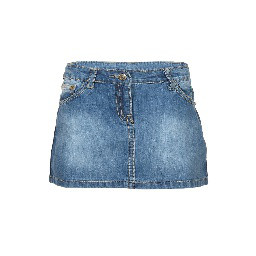

In [31]:
# The images is
print('This is image number: ',namesImages[1])

# It looks the following
im = Image.open('fashion_small/resized_images/10001.jpg')
Image.open('fashion_small/resized_images/10001.jpg')

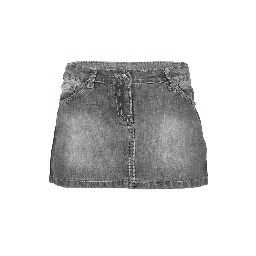

In [32]:
# Listing the data

imdata = list(im.getdata())

# Extracting the data to a list, to rebind it later

pixelList = [[i for i in pixel] for pixel in imdata]

listThosePixels = []

for pixelset in pixelList:
    listThosePixels += pixelset

# Creating the necessary ranges
redRange = np.arange(0,len(listThosePixels),3)
greenRange = np.arange(1,len(listThosePixels),3)
blueRange = np.arange(2,len(listThosePixels),3)

# let's now make the image grey

testImageGrey = [int(listThosePixels[r]*299/1000 + listThosePixels[g]*587/1000 + listThosePixels[b]*114/1000) for r,g,b in zip(redRange,greenRange,blueRange)]
testImageGreyBytes = bytes(testImageGrey)

# Let's display that grey images
Image.frombytes('L',(256,256),testImageGreyBytes)

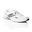

In [33]:
# From imagesTrainSMOTEGrey, the training set used below.

Image.frombytes('L',(32,32),bytes(list(imagesTrainSMOTEGrey[0])))# <- here the first image is shown, but choose any number
# from 0 to 76925 that you like!

### Conclusion on the example: Succes!

The SMOTE oversampled grey-scaled images are now used to obtain the results in table 5 and 6. 

### Obtaining results on the SMOTE oversampled grey-scaled images

In [34]:
#################################################### Define models below ####################################################

# Random Forest
rfCl = RandomForestClassifier(n_estimators=100, max_depth=None,n_jobs=-1)

# Multi-layer Perceptron (Neural Network)
mlpCl = MLPClassifier(solver='adam', alpha=1e-5,learning_rate = 'constant',
                      hidden_layer_sizes=(200,),batch_size = 'auto')

# Gradinent Boosting Classifier
gbCl = ensemble.GradientBoostingClassifier(n_estimators=10,n_iter_no_change=10,subsample = 0.5)

# Logistic Regression Classifier
lrCl = LogisticRegression(solver='lbfgs',multi_class='multinomial',n_jobs=-1)

# Combine the classifiers to a list 
classifiers = [rfCl,mlpCl,gbCl,lrCl]

# Specify names for the classifiers, otherwise will they be name by numbers.... Which you obiviously don't want.. Do you?
names = ['RandomForest','MultiLayerPerceptron','GradientBoosting','LogisticRegression']

# Let's run some models
results_grey, predictions_grey = evaluatePerformance([imagesTrainSMOTEGrey,labelsTrainSMOTE],
                                                     [imagesValGrey,labelsVal],classifiers,names,'initial_SMOTE_Grey')

In [35]:
print('The dimensions of the training data is:\n\nFeatures: %i\nObservations: %i' %(len(imagesTrainSMOTEGrey[0]),
                                                                                    len(imagesTrainSMOTEGrey)))
print('\nThe dimensions of the validation data is:\n\nFeatures: %i\nObservations: %i' %(len(imagesValGrey[0]),
                                                                                        len(imagesValGrey)))

The dimensions of the training data is:

Features: 1024
Observations: 76926

The dimensions of the validation data is:

Features: 1024
Observations: 8821


In [36]:
print('Table 5 - Results on the SMOTE-sampled grey-scaled images')
results_grey

Table 5 - Results on the SMOTE-sampled grey-scaled images


,Accuracy,Precision,Recall,F1-score,Runtime
RandomForest,0.980388,0.978353,0.980388,0.979315,44.448766
MultiLayerPerceptron,0.79118,0.900509,0.79118,0.84129,164.315452
GradientBoosting,0.802743,0.907239,0.802743,0.843304,200.865530
LogisticRegression,0.872804,0.929547,0.872804,0.89613,45.570812


In [37]:
print('Table 6 - Predictions based on the SMOTE-sampled grey-scaled images')
predictions_grey

Table 6 - Predictions based on the SMOTE-sampled grey-scaled images


,0,1,2,3,4,5
Dataset,4275,2252,1840,428,21,5
RandomForest,4277,2279,1823,437,3,2
MultiLayerPerceptron,3775,2027,1595,324,1097,3
GradientBoosting,3526,1801,1789,919,642,144
LogisticRegression,3877,1933,1842,701,414,54


Table 5 contains some interesting insights, and the first thing to notice is that the runtime for all classifiers has been reduced significantly, comparing table 5 with table 1 and table 3, which was crucial in order to be able to run the Cross-validation. Secondly, all classifiers except Logistic Regression have improved their performance, both in terms of accuracy and the F1-score. However, looking at the confusion matrices reveals that all but Random Forest has improved their prediction of the minority classes. Interesting is it that the Random Forest can’t correctly classify almost any of the observations belonging to minority classes.

The next thing to do is to tune the individual model configurations, by using Cross-validation.


### Performing Cross-validation

The training set and the validation set are merged back together, before performing cross-validation of the different model configurations. This is done to ensure that as much of the data is being utilised in the Cross-validation procedure. 
A parameter grid is specified for each model, and along with a dictionary of score metrics used to evaluate the models. The scoring metrics used are precision, recall, f1-score and accuracy. 
The best score and model configuration, for each of the models, is seen below.


In [38]:
# Remember that we wished to merge the training and validation set used in the benchmarking procedure.
# For grey images
imagesTrainGrey = np.concatenate([imagesTrainGrey,imagesValGrey])
imagesTrain = np.concatenate([imagesTrain,imagesVal])
labelsTrain = np.concatenate([labelsTrain,labelsVal])

start = time.time()
# Sample the data
sm = SMOTE(random_state=2019,n_jobs = -1)
imagesTrainSMOTEGreyTotal, labelsTrainSMOTEGreyTotal = sm.fit_resample(imagesTrainGrey, labelsTrain)

print('It took %.3f seconds'%(time.time()-start))

It took 89.227 seconds


In [39]:
# Either reading in the CV-generated data or generated it - Be aware that it took around 4 hours on my laptop.
# If one wishes to generate the data, just delete the CV folder.

# Combine the classifiers to a list 
classifiers = [rfCl,mlpCl,gbCl,lrCl]

# Specify names for the classifiers, otherwise will they be name by numbers.... Which you obiviously don't want.. Do you?
names = ['RandomForest','MultiLayerPerceptron','GradientBoosting','LogisticRegression']

folders = os.listdir()

if 'CV' in folders:
    
    # Read in the data from the folder 'CV'
    
    best_score = {}
    best_setting = {}
    
    # Loading in the accuracy data
    with open('CV/Accuracy.txt','r') as file:
        accuracies = file.readlines()
    
    # Processing the data    
    for element in accuracies:
        element = re.sub('\n','',element)
        element = re.split('\t',element)
        best_score[element[0]] = float(element[1])
    
    # Loading in the settings
    j,k = 0,1
    with open('CV/Settings.txt','r') as file:
        settings = file.readlines()
    
    # Processing the data
    settings = [re.sub('\n','',setting) for setting in settings if re.sub('\n','',setting) != '']
    whereAreThey = [i for i,e in enumerate(settings) if e in names]+[len(settings)-1]

    for name in names:
        tempDict = {}
        if (whereAreThey[k]-(whereAreThey[j]+1)) > 0:

            for numberofSettings in np.arange(whereAreThey[k]-(whereAreThey[j]+1)):

                temp = settings[(whereAreThey[j]+1)+numberofSettings]
                temp = re.split('\t',temp)
                tempDict[temp[0]] = temp[1]
        else:

            temp = settings[(whereAreThey[k])]
            temp = re.split('\t',temp)
            tempDict[temp[0]] = temp[1]

        best_setting[name] = tempDict
        j += 1
        k += 1
    
else:
    
    # Generate the CV Data
    
    # Let's do that fancy Cross-Validation thing...
    # The first thing needed is to define the dictionaries with the parameters to be cross validated for each of the models 
    # considered here.

    # Random Forest
    rfDict = {'n_estimators':[10,30,100],'max_features':[7,32,145]}

    # Multi Layer Perceptron
    mlpDict = {'hidden_layer_sizes':[(200,),(500,),(500,500,)]}

    # Gradient Boosting Classifier
    gbDict = {'max_features': [32,145],'max_depth':[3,5,8],'learning_rate':[0.1,0.5]}

    # Logistic Regression
    lrDict = {'C':[0.001,0.01,0.1,1,10,100]}

    # Create a list to hold all the parameter dictionaries, keep them in the same order as the classifier list from earlier,
    # which happens to be the dictionaries above are written in ;)
    paramsList = [rfDict,mlpDict,gbDict,lrDict]

    # Performing CV 
    scoring = ['precision_micro', 'recall_micro','f1_micro','accuracy']

    best_score = {}
    best_setting = {}

    for name,classifier,params in zip(names,classifiers,paramsList):    
        clf = GridSearchCV(classifier, params, cv=5,n_jobs = -1,scoring=scoring,refit = 'f1_micro',verbose = 1)
        clf.fit(imagesTrainSMOTEGreyTotal,labelsTrainSMOTEGreyTotal)

        best_score[name]=clf.best_score_
        best_setting[name]=clf.best_params_
    
    # Storing the data
    
    os.mkdir('CV')
    
    with open('CV/Accuracy.txt','w') as file:
        for model in best_score.items():
            file.write(model[0]+'\t'+str(model[1])+'\n')
            
    with open('CV/Settings.txt','w') as file:
        for model in best_setting.items():
            file.write(model[0]+'\n\n')
            for setting in model[1].items():
                file.write(setting[0]+'\t'+str(setting[1])+'\n')
            file.write('\n')

In [40]:
best_score

{'RandomForest': 0.9947551084074248,
 'MultiLayerPerceptron': 0.8337622835751053,
 'GradientBoosting': 0.9847137732023086,
 'LogisticRegression': 0.9124064108563407}

In [41]:
best_setting

{'RandomForest': {'max_features': '32', 'n_estimators': '100'},
 'MultiLayerPerceptron': {'hidden_layer_sizes': '(200,)'},
 'GradientBoosting': {'learning_rate': '0.5',
  'max_depth': '8',
  'max_features': '145'},
 'LogisticRegression': {'C': '0.01'}}

The best scores indicate that something interesting could have occurred with respect to Gradient Boosting and Logistic Regression, as a result of the individual model optimisation done using the Cross-validation.
Looking at the best settings for each of the models reveals that some further improvements could be done for some of the models. However, this is not done in this project because the computational requirements for doing so is beyond what is available to the author.

How can one see if the best settings reveal if models could benefit from further improvements, is a natural question to ask. Generally, if the level of any of the parameters, in the best setting for a model, is found to being either the lower or upper bound, then it is an indication that either a new lower or upper bound show be explored, and potential improvements could be made. Cross-validation can be an iterative process if the computational power allows it. 

This is the case for both Random Forest and Gradient Boosting, which is also the two highest scoring models. 

The best setting of the Random Forest involves the maximum number of trees tried out, and this number could be increased for potential improvements.

The best setting of the Gradient Boosting involves the maximum of all the three parameters considered here, that certainly indicates that some improvement could be done.

It is now time to try the best settings on the, up until now, unseen test set.

## Results

The results using the best settings, found through Cross-validation, is shown in table 7 and 8 below.

In [42]:
#################################################### Define models below ####################################################

# Random Forest
rfCl = RandomForestClassifier(n_estimators=100, max_features=32,n_jobs=-1)

# Multi-layer Perceptron (Neural Network)
mlpCl = MLPClassifier(solver='adam', alpha=1e-5,learning_rate = 'constant',
                      hidden_layer_sizes=(200,),batch_size = 'auto')

# Gradinent Boosting Classifier
gbCl = ensemble.GradientBoostingClassifier(n_estimators=10,n_iter_no_change=10,max_depth = 8,
                                           max_features = 145,learning_rate=0.5)

# Logistic Regression Classifier
lrCl = LogisticRegression(solver='lbfgs',multi_class='multinomial',n_jobs=-1,C = 0.01)

# Combine the classifiers to a list 
classifiers = [rfCl,mlpCl,gbCl,lrCl]

# Specify names for the classifiers, otherwise will they be name by numbers.... Which you obiviously don't want.. Do you?
names = ['RandomForest','MultiLayerPerceptron','GradientBoosting','LogisticRegression']

# Let's run some models
results_grey, predictions_grey = evaluatePerformance([imagesTrainSMOTEGreyTotal,labelsTrainSMOTEGreyTotal],
                                                     [imagesTestGrey,labelsTest],classifiers,names,'Best_SMOTE_Grey')

In [43]:
print('Table 7 - Results for the best versions of the models')
results_grey

Table 7 - Results for the best versions of the models


,Accuracy,Precision,Recall,F1-score,Runtime
RandomForest,0.983789,0.981548,0.983789,0.982639,61.815632
MultiLayerPerceptron,0.19941,0.553642,0.19941,0.221644,364.688147
GradientBoosting,0.973019,0.972946,0.973019,0.97296,373.656378
LogisticRegression,0.874391,0.930078,0.874391,0.897118,40.333262


In [44]:
print('Table 8 - Predictions for the best versions of the models')
predictions_grey

Table 8 - Predictions for the best versions of the models


,0,1,2,3,4,5
Dataset,4274,2253,1840,428,21,5
RandomForest,4277,2281,1832,427,1,3
MultiLayerPerceptron,82,508,1641,77,15,6498
GradientBoosting,4257,2268,1828,444,19,5
LogisticRegression,3904,1920,1839,732,378,48


Looking at table 7, does a first sight, looks promising, with great improvements, in terms of higher accuracy and F1-score, in Gradient Boosting and Logistic Regression. There is a minor improvement in Random Forest and the neural network is way off. However, looking at the confusion matrices reveal another side of the coin. Gradient Boosting has lost some ability to classify the minority classes compared to previously. Logistic Regression is almost unchanged and Random Forest hasn’t almost not changed. That is a little bit disappointing but looking back at the procedure surrounding the cross-validation reveals a major mistake, which is to be discussed below. 

## Discussion

At this point, it is natural to reflect over the results obtained, and highlight some of the limitations in the project, which potentially could have a substantial effect of the results. Looking back at the entire process fosters at least four interesting things to discuss, whereas the two are closely related, as they both involve the training time (Runtime essentially); 

* What seems to be wrong with the Neural Network, and what can be done? 
* Is it possible to reduce the number of features/dimensions of the data?
* Should a subset of the original data have been used?
* Cross-validation performed wrong, a common mistake.

It does perhaps seem quite odd that the Neural Network perform so badly, and not being able to do better than a random guess at best, when the most successful approach for images classification currently is the Neural Network (Shridhar, 2018) (Griffiths, 2016) (Fogg, 2016). However, looking at the network configurations of industry-standard Neural Networks reveals that the set-up employed here is way too simple. One fine example is the network employed by (Shridhar, 2018), which uses 572 layers and has over 54.000.000 parameters. Award-winning Neural Networks needs a vast amount of training data, for the parameters to be somewhat useful, which is why parameters of pre-trained Neural Networks are available for other researchers to use. Keras is a neural network API, which allows the researcher to implement custom and pre-trained networks quite easily. From their own introduction; 

_Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research._

The pre-trained networks are all trained on images from ImageNet, which is the largest collection of images for classification available today. 
An interesting thing could have been to implement one of the networks based on ImageNet, to see how that changed the performance of the neural network. However, that is regarded as a task for future research. 

The next thing that is relevant to discuss is the number of features/dimensions, mainly because 1000+ features/dimension are costly in terms of runtime and using only the pixels is not necessarily enough to distinguish some of the smallest classes. A common step among award-winning approaches is to do feature engineering (Fogg, 2016). However, that seems only to be relevant when the approach at hand is an ensemble of average learners, which could be an ensemble of Random Forest's or Gradient Boosting Classifiers (typically employed through the revolutionary implementation XGBoost) with different configurations or a combination of multiple algorithms. The idea with the ensemble of different learners is that they individually catch different dynamics of the dataset, and if the learners a somewhat uncorrelated, then it can result in an extremely powerful learner when combined. 

Another thing to consider here is if it could be beneficial to use only a subset of the data, in order to reduce the runtime, which obviously is a burden for some of the algorithms employed. However, it does seem like a bad idea, having in mind that the two smallest classes make up 0.3% of the total data or 140 observations. 0.3% is already nothing, and that is why it is an interesting problem to try to solve, because this problem occurs in a lot of practical applications, like fraud detection, cancer detection and detection of investment anomalies. 
A better idea is to ramp up the computational power, by using GPU computing and potentially by using a cluster of GPUs' on, as an example Google cloud. 

Finally, I came to realise too late that I have made a stupid mistake with respect to the Cross-validation I have performed, even though the timing of the oversampling is discussed at the beginning of the Analysis section. The error that has been made, is that the oversampled data can't be used in the Cross-validation procedure, because that exactly violates the fundamental assumption of Cross-validation, namely that the test set should be unseen from the training perspective, which it isn't when the oversampled data is used for Cross-validation.
What should instead have been done, was that I should have written a CV procedure myself, where the oversampling occurred inside the Cross-validation, i.e. after the data has been split into a training and a validation set.
The implication of the oversampling taking place before the Cross-validation procedure is that overfitting occurs. Which is also one of the reasons why none of the models performs impressively, remember that the two minority classes constitute 0.3% of the total observations.

In appendix is included a custom Cross-validation procedure that I have written myself, but I didn't have the time to run on all the models. However, it is tested on Random Forest, and it does work but oversampling in every fold implies that it is slow.  

## Conclusion

The project has come to the end, and multi-class classification of a highly imbalanced dataset has been performed. Different steps have been taken to improve the classifications of the different algorithms used, as of reducing the features used and correcting the imbalance in the dataset. It has been demonstrated how synthetic oversampling of the dataset can improve the ability, at least of Gradient Boosting and Logistic Regression, to detect the minority classes (comparing the confusion matrices belonging to table 1 and 3). Furthermore, has it been shown how reducing the dimensions of the data, by converting the images to grey-scale instead of colour, in general, didn’t affect the performance of the classifiers but improve the runtime significantly (comparing the confusion matrices belonging to table 3 and 5). The grand finale should have been the effect of parameter tuning, using Cross-validation, for the different algorithms. However, not paying enough attention spoiled the fun for now. What we instead ended up with, was a classic example of overfitting, and models which were to some extent just as bad as initially (in terms of their ability to detect the minority classes).

In [45]:
end_total=time.time()
print('The total running time of the notebook was %.3f seconds'%(end_total-start_total))

The total running time of the notebook was 451.324 seconds


### Generating all results

To generate all results, delete the following folders: **t-SNE**, **predictions**,**data** and **CV**

**However, be aware that it will take a substantial amount of time.**

## References

Hu, L. and Ni, Q. (2017). IoT-Driven Automated Object Detection Algorithm for Urban Surveillance Systems in Smart Cities, IEEE Internet of Things Journal.

Goodnight, E. Z. (2011). What is Anti-Aliasing, and How Does it Affect My Photos and Images?, URL: https://www.howtogeek.com/73704/what-is-anti-aliasing-and-how-does-it-affect-my-photos-and-images/

Turkowski, K. (1990). Filters for Common Resampling Tasks, URL: http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf

Hastie, T., Tibshirani, R., & Friedman, J. (2008). The Elements of Statistical Learning. Springer.

Van Der Maaten, L. & Hinton, G. (2008). Visualizing Data using t-SNE. Journal of Machine Learning Research. 

Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial Intelligence Research.

Becker, Nick (2016). The Right Way to Oversample in Predictive Modeling. URL: https://beckernick.github.io/oversampling-modeling/

Srivastava, T. (2015). Tuning the parameters of your Random Forest model. URL: https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

Jain, A. (2016). Complete Guide to Parameter Tuning in Gradient Boosting (GBM) in Python. URL: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

Shridhar, K. (2018). Kaggle #1 Winning Approach for Image Classification Challenge. URL: https://medium.com/neuralspace/kaggle-1-winning-approach-for-image-classification-challenge-9c1188157a86

Griffiths, M. S. J. (2016). What algorithms are most successful on Kaggle? URL: https://www.kaggle.com/msjgriffiths/r-what-algorithms-are-most-successful-on-kaggle/report

Fogg, A. (2016). Anthony Goldbloom gives you the secret to winning Kaggle Competitions. URL: https://www.import.io/post/how-to-win-a-kaggle-competition/

Brownlee, J. (2016). How to Configure the Gradient Boosting Algorithm. URL: https://machinelearningmastery.com/configure-gradient-boosting-algorithm/

Deeplearning (No year listed). Multilayer Perceptron. URL: http://deeplearning.net/tutorial/mlp.html

Ravanshad, A. (2018). Gradient Boosting vs. Random Forest. URL: https://medium.com/@aravanshad/gradient-boosting-versus-random-forest-cfa3fa8f0d80

Donges, N. (2018). The Logistic Regression Algorithm. Machinlearning-blog.com, URL: https://machinelearning-blog.com/2018/04/23/logistic-regression-101/

Krizhevsky, A. (2009). Learning Multiple Layers of Features from Tiny Images. Link to datasets: https://www.cs.toronto.edu/~kriz/cifar.html 

Swalin, A. (2018). Choosing the Right Metrics for Evaluating Machine Learning Models – Part 2. URL: https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428

Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python. JMLR 12, pp. 2825-2830.

## Footnotes

[1] See under references: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

[2] Concepts/Filters - https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-filters

[3] Procedure used by one of the collectors, (Krizhevsky, 2009), of the famous _CIFAR-10_ and _CIFAR-100_ datasets, 
    see _Dataset layout/data_ via the link in the reference.

[4] https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

[5] https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert

## Appendix

### Confusion matrix for the initial prediction underlying table 1 and 2

GradientBoosting.txt


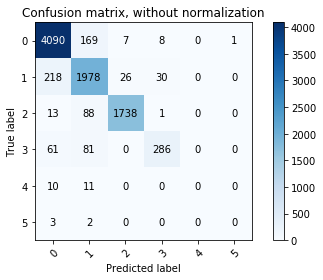

LogisticRegression.txt


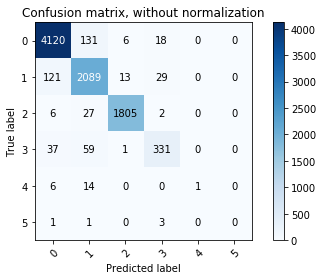

MultiLayerPerceptron.txt


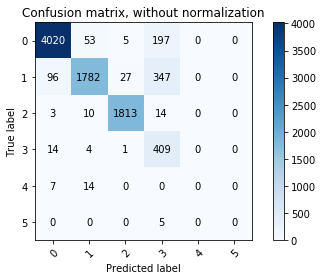

RandomForest.txt


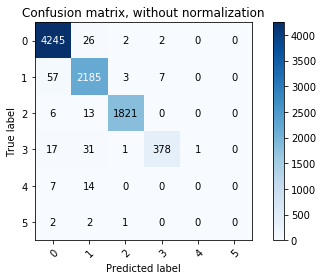

In [50]:
# Plotting the confusion matrix for each of the predictions generated

files = os.listdir('predictions/initial_2_predictions')

for predictions in files:
    if 'run' not in predictions:
        
        print(predictions)
        with open('predictions/initial_2_predictions/'+predictions,'r') as file:
            preds = np.array(file.read().split()).astype(int)

        plot_confusion_matrix(labelsVal, preds, classes=np.array(sorted(pd.unique(labelsVal))),
                      title='Confusion matrix, without normalization')
        plt.show()

### Confusion matrix for the prediction underlying table 3 and 4

GradientBoosting.txt


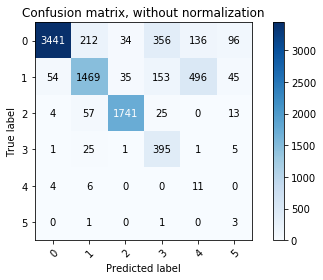

LogisticRegression.txt


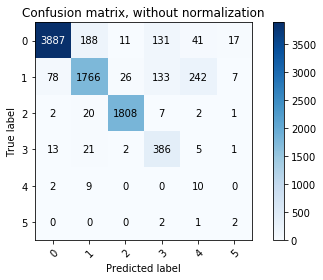

MultiLayerPerceptron.txt


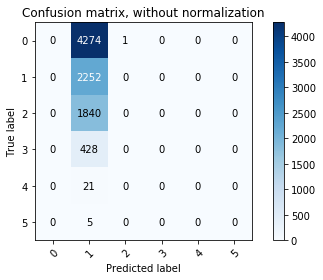

RandomForest.txt


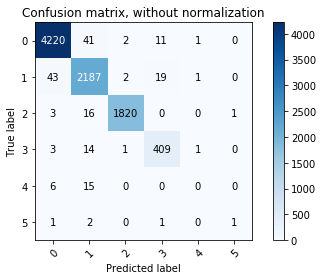

In [51]:
# Plotting the confusion matrix for each of the predictions generated

files = os.listdir('predictions/initialSMOTE_predictions')

for predictions in files:
    if 'run' not in predictions:
        
        print(predictions)
        with open('predictions/initialSMOTE_predictions/'+predictions,'r') as file:
            preds = np.array(file.read().split()).astype(int)

        plot_confusion_matrix(labelsVal, preds, classes=np.array(sorted(pd.unique(labelsVal))),
                      title='Confusion matrix, without normalization')
        plt.show()

### Confusion matrix for the prediction underlying table 5 and 6

GradientBoosting.txt


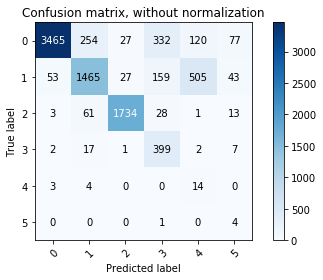

LogisticRegression.txt


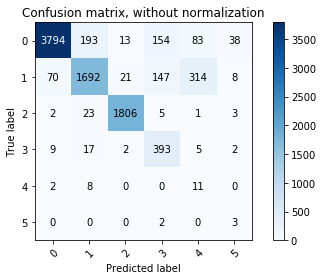

MultiLayerPerceptron.txt


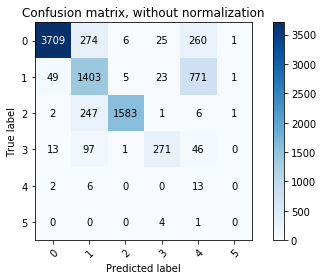

RandomForest.txt


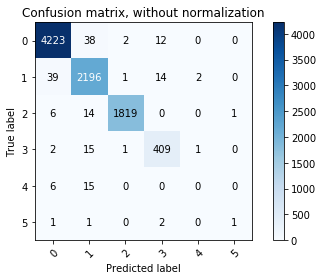

In [52]:
# Plotting the confusion matrix for each of the predictions generated

files = os.listdir('predictions/initial_SMOTE_Grey_predictions')

for predictions in files:
    if 'run' not in predictions:
        
        print(predictions)
        with open('predictions/initial_SMOTE_Grey_predictions/'+predictions,'r') as file:
            preds = np.array(file.read().split()).astype(int)

        plot_confusion_matrix(labelsVal, preds, classes=np.array(sorted(pd.unique(labelsVal))),
                      title='Confusion matrix, without normalization')
        plt.show()

### Confusion matrix for the prediction underlying table 7 and 8

GradientBoosting.txt


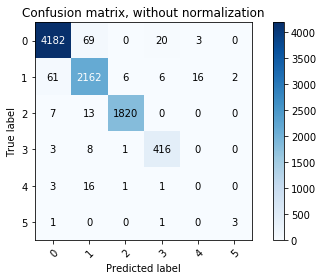

LogisticRegression.txt


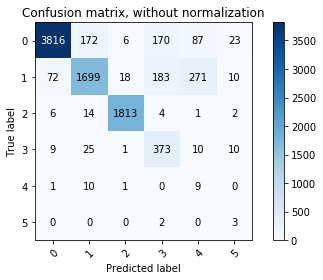

MultiLayerPerceptron.txt


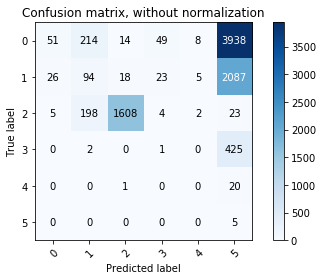

RandomForest.txt


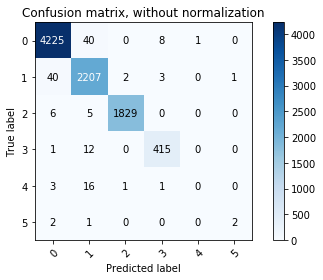

In [53]:
# Plotting the confusion matrix for each of the predictions generated

files = os.listdir('predictions/Best_SMOTE_Grey_predictions')

for predictions in files:
    if 'run' not in predictions:
        
        print(predictions)
        with open('predictions/Best_SMOTE_Grey_predictions/'+predictions,'r') as file:
            preds = np.array(file.read().split()).astype(int)

        plot_confusion_matrix(labelsTest, preds, classes=np.array(sorted(pd.unique(labelsTest))),
                      title='Confusion matrix, without normalization')
        plt.show()

### Custom Cross-Validation

In [54]:
def crossValidationCustom(classifier, name, params, features,labels,cv=5):
    print('The classifier on which custom Cross validation is performed is %s\n'% name)
    grid = list(ParameterGrid(params))
    accuracy = 0
    bestParams = []
    for setup in grid:
        print('The parameter combination under investigation is ', setup,'\n')
        skf = StratifiedKFold(n_splits=cv)
        truePred = 0
        for train_index, test_index in skf.split(features, labels):
            
            labelsTest = labels[test_index]
            labelsTrain = labels[train_index]
            featuresTest = features[test_index] 
            featuresTrain = features[train_index]
            
            # Sampling the training data, as it is surpossed to be in the correct way to do cross-validation with imbalanced data.
            
            sm = SMOTE(random_state=2019,n_jobs = -1)
            featuresTrainSMOTE, labelsTrainSMOTE = sm.fit_resample(featuresTrain, labelsTrain)
            
            # Now we can fit the classifier
            classifier.set_params(**setup)
            classifier.fit(featuresTrainSMOTE,labelsTrainSMOTE)#.set_params(setup)
            
            # Get predictions
            
            predictions = classifier.predict(featuresTest)
            
            truePred += sum(predictions==labelsTest)
                    
        tempAccuracy = truePred/(cv*len(labelsTest))
        print('The current Accuracy is: %.3f\n' % tempAccuracy)
        if tempAccuracy > accuracy:
            accuracy = tempAccuracy
            bestParams = setup
    return accuracy,bestParams

In [56]:
# The classifier list from earlier, any can be used in combination with their individual parameter dictionary
classifiers = [rfCl,mlpCl,gbCl,lrCl]

# Random Forest
rfDict = {'n_estimators':[10,30,100],'max_features':[7,32,145]}

start = time.time()
crossValidationCustom(rfCl,'RandomForest',rfDict,imagesTrainGrey,labelsTrain)
end=time.time()

print('The Cross-validation of Random Forest took %.3f seconds' % (end-start))

The classifier on which custom Cross validation is performed is RandomForest

The parameter combination under investigation is  {'max_features': 7, 'n_estimators': 10} 

The current Accuracy is: 0.971

The parameter combination under investigation is  {'max_features': 7, 'n_estimators': 30} 

The current Accuracy is: 0.977

The parameter combination under investigation is  {'max_features': 7, 'n_estimators': 100} 

The current Accuracy is: 0.979

The parameter combination under investigation is  {'max_features': 32, 'n_estimators': 10} 

The current Accuracy is: 0.974

The parameter combination under investigation is  {'max_features': 32, 'n_estimators': 30} 

The current Accuracy is: 0.980

The parameter combination under investigation is  {'max_features': 32, 'n_estimators': 100} 

The current Accuracy is: 0.981

The parameter combination under investigation is  {'max_features': 145, 'n_estimators': 10} 

The current Accuracy is: 0.976

The parameter combination under investigation i